# Nonlinear SVM Classification

Nonlinear dataset을 다루기 위한 방법 중 하나는 polynomial feature와 같은 feature를 추가하는 것이다. 아래 그림은 polynomial feature의 추가를 통해 왼쪽의 nonlinear dataset이 오른쪽처럼 linearly separable해지는 경우를 보여준다.

<br/>
<img src="./images/add_polynomial_feature.png" alt="add_polynomial_feature"> 
<br/>

사이킷런에서는 `Pipeline`에  `PolynomialFeatures` transformer를 추가해 이를 구현할 수 있다. 아래 코드는 moons dataset(2개의 반원을 binary classification하는 dataset)을 사용한 예제이다.

/home/young/anaconda3/envs/tf_2/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


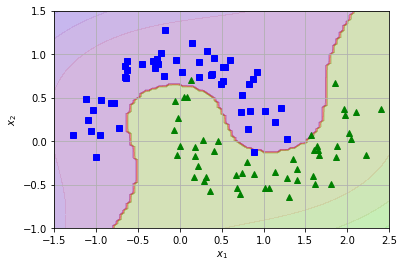

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scale", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge")),
])

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
polynomial_svm_clf.fit(X, y)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=10)
    plt.ylabel(r"$x_2$", fontsize=10)

    
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

    
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

## Polynomial Kernel

Polynomial feature를 추가하는 것은 SVM 뿐만 아니라 모든 머신러닝 알고리즘에서 잘 동작한다. 하지만 아주 complex한 dataset을 다루기 위해 high-degree의 polynomial feature를 추가한다면, model이 매우 느려질 것이다.

SVM에서는 **kernel trick**이라는 기적같은 mathematical technique을 사용해 high-degree의 아주 많은 polynomial feature를 직접 추가하지 않고도 추가한 것과 같은 결과를 얻을 수 있다.

이는 `SVC` class를 통해 다음과 같이 수행할 수 있다.

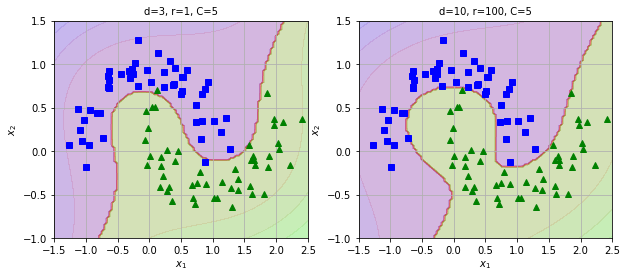

In [2]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])

high_poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
])

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1)
plt.title("d=3, r=1, C=5",fontsize=10)
poly_kernel_svm_clf.fit(X, y)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

fig.add_subplot(1, 2, 2)
plt.title("d=10, r=100, C=5",fontsize=10)
high_poly_kernel_svm_clf.fit(X, y)
plot_predictions(high_poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

위 코드는 각각 3rd-degree, 10th-degree의 polynomial kernel을 사용한 SVM classifier를 학습시킨다.

그림에서 알 수 있듯이, overfitting된다면, degree를 낮추고, underfitting된다면, degree를 높이면 된다. hyperparameter `coef0`는 모델이 high-degree polynomial feature와 low-degree polynomial feature에서 영향을 얼마나 받을 것인지를 조절한다.(high-degree vs low-degree)

## Adding Similarity Features

Nonlinear 문제를 해결하기 위한 또 다른 방법 중 하나는 각 instance가 특정한 **landmark**와 얼마나 비슷한지를 측정하는 **similarity function**을 사용해 feature를 추가하는 것이다.

앞서 살펴본 1차원 dataset을 예로 들어보자. $x_1=-2$와 $x_2=1$ 지점을 landmark로 설정하고, similarity function은 다음의 식으로 정의되는 **Gaussian Radial Basis Function(RBF)**를 사용해보자.

**Gaussian RBF**

$\phi_\gamma(\mathbf{x}, l) = \exp(-\gamma \| \mathbf{x}-l \|^2)$

Gaussian RBF는 bell-shaped function이며, landmark에서 멀수록 0에 가까워지고, landmark에 가까울수록 1에 가까워진다. $\gamma$를 0.3로 설정하고 아래 그림을 통해 직접 계산해보자.

<br/>
<img src="./images/gaussian_rbf.png" alt="gaussian_rbf"> 
<br/>

왼쪽 그림에서 $x_1=-1$은 첫번째 landmark(-2)와 1이 차이 나고, 두번째 landmark(1)와 2가 차이 난다. 이를 통해 계산해보면, 새로운 두 feature는 각각 $x_2 = \exp(-0.3\times1^2) \approx 0.74$, $x_3 = \exp(-0.3\times2^2) \approx 0.30$이다. 오른쪽 그림은 이와 같은 계산을 통해 모든 feature를 새롭게 나타낸 것이다. 변환된 dataset이 linearly separable해진 것을 알 수 있다.

landmark를 선택하는 간단한 방법은 dataset의 모든 instance로 선택하는 것이다. 이는 많은 차원을 만들어 내므로, 변환된 training set이 linearly separable할 수 있는 chance를 증가시켜준다. 

이 방법의 단점은 training set이 $m$개의 instance와 $n$개의 feature를 가질 경우, 변환된 training set은 $m$개의 instance와 $m$개의 feature를 가지게 된다는 것이다.(original feature는 제거할 경우) 따라서, training set이 매우 클 경우, feature수도 매우 커지게 된다.

## Gaussian RBF Kernel

Gaussian RBF kernel을 `SVC` class를 사용해보자. 아래 코드는 hyperparameter `gamma`($\gamma$)와 `C`를 조절해가며 각 결과를 나타내는 코드이다.

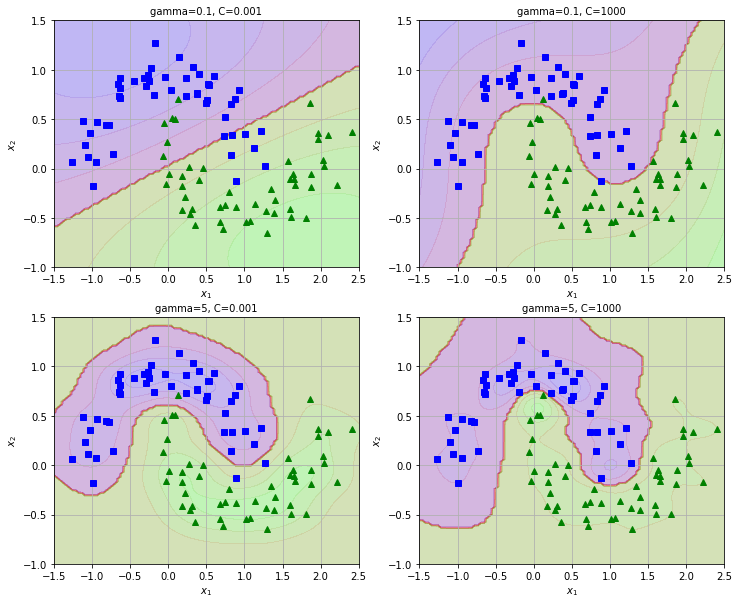

In [3]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyper_params = [(gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)]

fig = plt.figure(figsize=(12, 10))
for i, (gamma, C) in enumerate(hyper_params):
    ax = fig.add_subplot(2, 2, i+1)
    plt.title("gamma={}, C={}".format(gamma, C), fontsize=10)
    
    rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel='rbf', gamma=gamma, C=C))
    ])
    
    rbf_kernel_svm_clf.fit(X, y)
    plot_predictions(rbf_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

`gamma`가 커지면 bell-shaped curve가 좁아지며, 각 instance들의 영향 범위가 작아져 decision boundary가 불규칙적이고 각 instance에 따라 구불구불해진다. 반대로 `gamma`가 작아지면, bell-shaped curve가 넓어지고, 각 instance들의 영향 범위가 넓어져 decision boundary가 더 smooth해진다.

따라서 $\gamma$는 regularization hyperparameter와 같이 동작한다는 것을 알 수 있다. 모델이 overfitting일 경우, `gamma`를 줄이고, underfitting일 경우, `gamma`를 키우면 된다.(`C` hyperparameter와 유사)

RBF kernel외에 다른 kernel들도 존재하지만 잘 사용되지 않는다. 예를 들어, 몇몇 kernel은 특정 data structure에 특화된 경우가 있다. *String kernel*은 text document나 DNA sequence의 classification에 종종 사용된다.(*string subsequence kernel* 또는 *Levenstein distance*에 기반한 kernel)

kernel을 선택하는 방법은 일반적으로 가장 먼저 linear kernel(`LinearSVC`)을 사용하면 된다. 특히 training set이 매우 크거나 feature수가 매우 많은 경우이다. 만약, training set이 크지 않다면, Gaussian RBF kernel을 시도해보면 좋다. 이는 대부분의 경우에 잘 동작한다. 만약, 시간과 컴퓨팅파워가 충분하다면 cross_validation과 grid search를 통해 여러 kernel들을 시도해 볼 수 있다.(특히 data structure에 특화된 kernel이 있는 경우)


## Computational Complexity

`LinearSVC` class는 linear SVM을 위한 최적화된 알고리즘을 구현한 liblinear 라이브러리를 사용한다. 이는 kernel trick을 지원하지는 않지만, training instance와 feature의 수에 linear하게 늘어난다.(training time complexity : 대략 $O(m\times n)$)

알고리즘은 높은 정확도를 원할 경우 더 오랜 시간이 걸리며, 이는 tolerance hyperparamter $\epsilon$ (사이킷런에서는 `tol`)에 의해 조절될 수 있다. 대부분의 classification task에서 default 값을 사용하면 잘 동작한다.

`SVC` class는 kernel trick 알고리즘을 구현한 libsvm 라이브러리에 기반한다. training time complexity는 보통 $O(m^2 \times n)$와 $O(m^3 \times n)$ 사이이므로 training set의 크기가 커짐에 따라 매우 느려진다. 따라서, 이 알고리즘은 complex하지만 training set이 작거나 중간정도의 크기일 경우에 적합하다. 하지만 feature의 수(특히 nonzero feature가 적은 sparse feature인 경우)에 따라서는 instance당 nonzero feature의 평균 크기에 비례하므로 크게 느려지지 않는다.

다음 그림은 사이킷런의 SVM classification class들을 비교한 것이다.

|Class|Time complexity|Out-of-core support|Scaling required|Kernel trick|
|-----|---------------|-------------------|----------------|------------|
|`LinearSVC`|O(m × n)|No|Yes|No|
|`SGDClassifier`|O(m × n)|Yes|Yes|No|
|`SVC`|O(m2 × n) to O(m3 × n)|No|Yes|Yes|